# Preprocessing The Data


## Imports

In [0]:
# imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [0]:
# READ CSV using pandas
filepath = '/content/'
season_stats = pd.read_csv(filepath+'seasons_stats.csv').drop('Unnamed: 0',axis=1)
ss_18_20 = pd.read_csv(filepath+'season_stats_2018-2020.csv').drop('Unnamed: 0',axis=1)
vote = pd.read_csv(filepath+'voting.csv').drop(['AGE','Unnamed: 0'],axis=1)
team_performance = pd.read_csv(filepath+'team_performance.csv')


## Creating Dataset

In [0]:
SS = season_stats[season_stats['YEAR'] >= 1980]

In [0]:
# Remove unwanted rows and columns #DO NOT RE-RUN 
#SS = SS.drop(columns=["Unnamed: 0"])
SS = SS[SS.YEAR.notnull()]
#remove special characters in the Players col
SS['PLAYER'] = SS['PLAYER'].replace({'\*':''}, regex=True)

In [0]:
# add missing data to the set
SS = pd.concat([SS,ss_18_20],ignore_index=True)

In [0]:
# merge season stats and voting
full_stats = pd.merge(SS, vote,  how='left', left_on=['YEAR','PLAYER','TEAM'],
                      right_on = ['YEAR','PLAYER','TEAM'])

In [0]:
full_stats = full_stats.fillna(0)

In [8]:
full_stats

,PLAYER,YEAR,POS,AGE,TEAM,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,First,PW,PM,RANK
0,Kareem Abdul-Jabbar,1980.0,C,32.0,LAL,82.0,0.0,3143.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,835.0,1383.0,0.604,0.0,1.0,0.000,835.0,1382.0,0.604,0.604,364.0,476.0,0.765,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0,147.0,147.0,221.0,1.0
1,Tom Abernethy,1980.0,PF,25.0,GSW,67.0,0.0,1222.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,153.0,318.0,0.481,0.0,1.0,0.000,153.0,317.0,0.483,0.481,56.0,82.0,0.683,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0,0.0,0.0,0.0,0.0
2,Alvan Adams,1980.0,C,25.0,PHO,75.0,0.0,2168.0,19.2,0.571,0.002,0.270,8.2,22.4,15.4,21.6,2.3,1.4,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,465.0,875.0,0.531,0.0,2.0,0.000,465.0,873.0,0.533,0.531,188.0,236.0,0.797,158.0,451.0,609.0,322.0,108.0,55.0,218.0,237.0,1118.0,0.0,0.0,0.0,0.0
3,Tiny Archibald,1980.0,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,383.0,794.0,0.482,4.0,18.0,0.222,379.0,776.0,0.488,0.485,361.0,435.0,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,2.0,2.0,221.0,5.0
4,Dennis Awtrey,1980.0,C,31.0,CHI,26.0,0.0,560.0,7.4,0.524,0.000,0.833,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,27.0,60.0,0.450,0.0,0.0,0.000,27.0,60.0,0.450,0.450,32.0,50.0,0.640,29.0,86.0,115.0,40.0,12.0,15.0,27.0,66.0,86.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20918,Thaddeus Young,2020.0,PF,31.0,CHI,64.0,16.0,1591.0,13.3,0.521,0.369,0.120,6.2,16.1,10.9,11.3,2.8,1.4,13.9,19.7,-0.2,2.1,1.9,0.058,-1.4,0.2,-1.1,0.4,269.0,601.0,0.448,79.0,222.0,0.356,190.0,379.0,0.501,0.513,42.0,72.0,0.583,94.0,221.0,315.0,117.0,92.0,23.0,102.0,134.0,659.0,0.0,0.0,0.0,0.0
20919,Trae Young,2020.0,PG,21.0,ATL,60.0,60.0,2120.0,23.9,0.595,0.455,0.448,1.6,11.5,6.5,45.6,1.4,0.3,16.2,34.9,5.4,0.5,5.9,0.134,6.3,-2.3,4.0,3.2,546.0,1249.0,0.437,205.0,568.0,0.361,341.0,681.0,0.501,0.519,481.0,559.0,0.860,32.0,223.0,255.0,560.0,65.0,8.0,289.0,104.0,1778.0,0.0,0.0,0.0,0.0
20920,Cody Zeller,2020.0,C,27.0,CHO,58.0,39.0,1341.0,18.8,0.576,0.157,0.374,12.6,21.2,16.7,11.3,1.5,1.7,11.9,20.8,2.4,1.2,3.6,0.129,0.2,-0.8,-0.6,0.5,251.0,479.0,0.524,18.0,75.0,0.240,233.0,404.0,0.577,0.543,122.0,179.0,0.682,160.0,251.0,411.0,88.0,40.0,25.0,75.0,140.0,642.0,0.0,0.0,0.0,0.0
20921,Ante Žižić,2020.0,C,23.0,CLE,22.0,0.0,221.0,16.4,0.597,0.000,0.264,9.0,24.4,16.6,4.2,1.5,1.9,11.1,17.5,0.3,0.2,0.5,0.106,-1.7,-1.5,-3.2,-0.1,41.0,72.0,0.569,0.0,0.0,0.000,41.0,72.0,0.569,0.569,14.0,19.0,0.737,18.0,48.0,66.0,6.0,7.0,5.0,10.0,27.0,96.0,0.0,0.0,0.0,0.0


In [0]:
##### PLAYERS TO DELETE ######
##### ONLY RUN ONCE DURING RUNTIME #####
# DeAndre Liggins 2014 
# index 16839
# had the all time highest win share because he only played one game and highest PER
# Naz Mitrou-Long
# index 19348
# had the all time highest win share because he only played one game and highest PER
pos = [16839,19348]
full_stats.drop(full_stats.index[pos], inplace=True)

#MVP Possible Models


## SVM

In this section I used an SVM model to narrow down as small of a list of candidates for each MVP voting year. 

In [0]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import seaborn as sns
from scipy import stats

In [0]:
data = full_stats

I want to only be able to find how the top five players in voting are. Three points weren't a thing until 89' and only became the meta in the modern NBA. May have to look at only a subset of the data beacause we are looking to predict future voting and that relates more to modern NBA values.

In [0]:
# drop_svm = ['POS','AGE','TEAM','GS','3PAr','FTr','ORB%','DRB%','TRB%'
# ,'AST%','STL%','BLK%','TOV%','USG%','OBPM','DBPM','BPM','VORP','FGA',
# '3P','3PA','2P','2PA','2P%','FT','FTA','First','PW','PM','PF']

In [0]:
drop_final = ['POS','AGE','TEAM','GS','3PAr','FTr','ORB%','DRB%','TRB%'
,'AST%','STL%','BLK%','TOV%','USG%','OBPM','DBPM','BPM','VORP','FGA',
'3P','3PA','2P','2PA','2P%','FT','FTA','First','PW','PM','PF','ORB','DRB','FG',
'TOV','MP','WS']

In [0]:
data = data.drop(drop_final,axis=1)

In [16]:
data = data[data['YEAR'] > 2003]
print(data)

                    PLAYER    YEAR     G   PER  ...   STL   BLK     PTS  RANK
10739  Shareef Abdur-Rahim  2004.0  85.0  19.9  ...  68.0  37.0  1384.0   0.0
10740  Shareef Abdur-Rahim  2004.0  53.0  21.2  ...  44.0  19.0  1065.0   0.0
10741  Shareef Abdur-Rahim  2004.0  32.0  16.5  ...  24.0  18.0   319.0   0.0
10742          Malik Allen  2004.0  45.0  10.5  ...  12.0  28.0   191.0   0.0
10743            Ray Allen  2004.0  56.0  21.7  ...  71.0  11.0  1287.0   0.0
...                    ...     ...   ...   ...  ...   ...   ...     ...   ...
20918       Thaddeus Young  2020.0  64.0  13.3  ...  92.0  23.0   659.0   0.0
20919           Trae Young  2020.0  60.0  23.9  ...  65.0   8.0  1778.0   0.0
20920          Cody Zeller  2020.0  58.0  18.8  ...  40.0  25.0   642.0   0.0
20921           Ante Žižić  2020.0  22.0  16.4  ...   7.0   5.0    96.0   0.0
20922          Ivica Zubac  2020.0  64.0  21.0  ...  13.0  60.0   511.0   0.0

[10182 rows x 18 columns]


In [0]:
# make train and test sets for first set of predictions
ranking = range(1,3) 
train = data[data['YEAR'] <= 2015]
#print(train.iloc[:,2:-5])
x_train = scale(train.iloc[:,2:-1])
y_train = train['RANK'].apply(lambda x: -1 if (x not in ranking) else 1)
test = data[data['YEAR'] > 2015]
x_test = scale(test.iloc[:,2:-1])
y_test = test['RANK'].apply(lambda x: -1 if (x not in ranking) else 1)

In [18]:
print("x_train:",np.shape(x_train))
print("y_train:",np.shape(y_train))
print("x_test:",np.shape(x_test))
print("y_test:",np.shape(y_test))

x_train: (7014, 15)
y_train: (7014,)
x_test: (3168, 15)
y_test: (3168,)


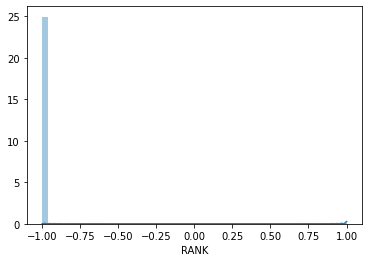

In [19]:
# Checking the distribution of the labels
sns.distplot(y_test)

In [20]:
clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.9990530303030303


### Checking Results

In [0]:
d = {'player': test['PLAYER'], 'year': test['YEAR'], 'RANK': (test['RANK']), 'pred': y_pred}
df = pd.DataFrame(data=d)

In [22]:
df[df.pred == 1]

,player,year,RANK,pred
17870,Stephen Curry,2016.0,1.0,1
17891,Kevin Durant,2016.0,5.0,1
18542,James Harden,2017.0,2.0,1
18890,Russell Westbrook,2017.0,1.0,1
19159,James Harden,2018.0,1.0,1
19610,Giannis Antetokounmpo,2019.0,1.0,1
19858,James Harden,2019.0,2.0,1


In [23]:
# create a new df so we can see if can predict the actual MVP in this list
narrowed = test
narrowed['PRED'] = y_pred
narrowed = narrowed[narrowed['PRED'] == 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
narrowed

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,RANK,PRED
17870,Stephen Curry,2016.0,79.0,31.5,0.669,13.8,4.1,0.318,0.504,0.454,0.630,0.908,430.0,527.0,169.0,15.0,2375.0,1.0,1
17891,Kevin Durant,2016.0,72.0,28.2,0.634,11.0,3.5,0.270,0.505,0.387,0.573,0.898,589.0,361.0,69.0,85.0,2029.0,5.0,1
18542,James Harden,2017.0,81.0,27.3,0.613,11.5,3.6,0.245,0.440,0.347,0.525,0.847,659.0,906.0,120.0,37.0,2356.0,2.0,1
18890,Russell Westbrook,2017.0,81.0,30.6,0.554,8.5,4.6,0.224,0.425,0.343,0.476,0.845,864.0,840.0,133.0,31.0,2558.0,1.0,1
19159,James Harden,2018.0,72.0,29.8,0.619,11.6,3.8,0.289,0.449,0.367,0.541,0.858,389.0,630.0,126.0,50.0,2191.0,1.0,1
19610,Giannis Antetokounmpo,2019.0,72.0,30.9,0.644,8.9,5.5,0.292,0.578,0.256,0.599,0.729,898.0,424.0,92.0,110.0,1994.0,1.0,1
19858,James Harden,2019.0,78.0,30.6,0.616,11.4,3.8,0.254,0.442,0.368,0.541,0.879,518.0,586.0,158.0,58.0,2818.0,2.0,1


## Selecting MVP

In [0]:
# XGBoost
import xgboost
from sklearn.metrics import explained_variance_score

In [0]:
drop_final = ['POS','AGE','TEAM','GS','3PAr','FTr','ORB%','DRB%','TRB%'
,'AST%','STL%','BLK%','TOV%','USG%','OBPM','DBPM','BPM','VORP','FGA',
'3P','3PA','2P','2PA','2P%','FT','FTA','First','PW','PM','PF','ORB','DRB','FG',
'TOV','MP','WS']

In [0]:
data = full_stats[full_stats['RANK'] != 0]

In [0]:
data = data.drop(drop_final,axis=1)

In [0]:
data = data[data['YEAR'] > 2005]
data = data[data['RANK'] <= 5]


In [30]:
data

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,RANK
11963,Chauncey Billups,2006.0,81.0,23.4,0.602,12.7,2.8,0.254,0.418,0.433,0.509,0.894,252.0,699.0,71.0,8.0,1495.0,5.0
11989,Kobe Bryant,2006.0,80.0,28.0,0.559,11.6,3.7,0.224,0.450,0.347,0.491,0.850,425.0,360.0,147.0,30.0,2832.0,4.0
12165,LeBron James,2006.0,79.0,28.1,0.568,12.0,4.3,0.232,0.480,0.335,0.515,0.738,556.0,521.0,123.0,66.0,2478.0,2.0
12267,Steve Nash,2006.0,79.0,23.3,0.632,10.3,2.1,0.212,0.512,0.439,0.583,0.921,333.0,826.0,61.0,12.0,1489.0,1.0
12275,Dirk Nowitzki,2006.0,81.0,28.1,0.589,13.5,4.3,0.275,0.480,0.406,0.515,0.901,728.0,226.0,58.0,83.0,2151.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19610,Giannis Antetokounmpo,2019.0,72.0,30.9,0.644,8.9,5.5,0.292,0.578,0.256,0.599,0.729,898.0,424.0,92.0,110.0,1994.0,1.0
19750,Stephen Curry,2019.0,69.0,24.4,0.641,7.2,2.5,0.199,0.472,0.437,0.604,0.916,369.0,361.0,92.0,25.0,1881.0,5.0
19831,Paul George,2019.0,77.0,23.3,0.583,7.0,4.9,0.201,0.438,0.386,0.529,0.839,628.0,318.0,170.0,34.0,2159.0,3.0
19858,James Harden,2019.0,78.0,30.6,0.616,11.4,3.8,0.254,0.442,0.368,0.541,0.879,518.0,586.0,158.0,58.0,2818.0,2.0


In [0]:
# make train and test sets 
train = data[data['YEAR'] <= 2016]
#print(train.iloc[:,2:-5])
x_train = scale(train.iloc[:,2:-1])
y_train = train['RANK'].apply(lambda x: 0 if (x != 1) else 1)
test = data[data['YEAR'] > 2016]
x_test = scale(test.iloc[:,2:-1])
y_test = test['RANK'].apply(lambda x: 0 if (x != 1) else 1)

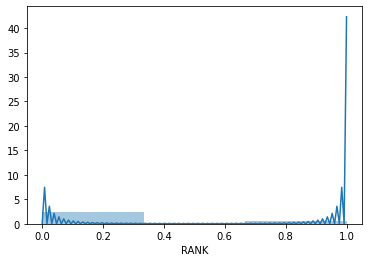

In [32]:
# Checking the distribution of the labels
sns.distplot(y_test)

### XGB

In [0]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)


In [34]:
xgb.fit(x_train,y_train)

[20:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [35]:
predictions = xgb.predict(x_test)
t_predict = xgb.predict(x_train)
print(explained_variance_score(predictions,y_test))

-1.5414859195383928


In [0]:
# candidates
#drop_narrowed = ['ORB',	'DRB','FG','TOV','MP','WS']
#candidates = narrowed.drop(drop_narrowed,axis=1)
candidates = narrowed
cand_scaled = scale(candidates.iloc[:,2:-2])

In [37]:
print("x_train:",np.shape(x_train))
print("y_train:",np.shape(y_train))
print("x_test:",np.shape(x_test))
print("y_test:",np.shape(y_test))
print("candidates:",np.shape(cand_scaled))

x_train: (55, 15)
y_train: (55,)
x_test: (15, 15)
y_test: (15,)
candidates: (7, 15)


In [0]:
n_pred = xgb.predict(cand_scaled)

In [0]:
candidates['X_PRED'] = n_pred

In [40]:
candidates.sort_values(['YEAR', 'X_PRED'], ascending=[True, False])

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,RANK,PRED,X_PRED
17870,Stephen Curry,2016.0,79.0,31.5,0.669,13.8,4.1,0.318,0.504,0.454,0.630,0.908,430.0,527.0,169.0,15.0,2375.0,1.0,1,0.724705
17891,Kevin Durant,2016.0,72.0,28.2,0.634,11.0,3.5,0.270,0.505,0.387,0.573,0.898,589.0,361.0,69.0,85.0,2029.0,5.0,1,0.191620
18890,Russell Westbrook,2017.0,81.0,30.6,0.554,8.5,4.6,0.224,0.425,0.343,0.476,0.845,864.0,840.0,133.0,31.0,2558.0,1.0,1,0.520304
18542,James Harden,2017.0,81.0,27.3,0.613,11.5,3.6,0.245,0.440,0.347,0.525,0.847,659.0,906.0,120.0,37.0,2356.0,2.0,1,0.282296
19159,James Harden,2018.0,72.0,29.8,0.619,11.6,3.8,0.289,0.449,0.367,0.541,0.858,389.0,630.0,126.0,50.0,2191.0,1.0,1,0.180644
19858,James Harden,2019.0,78.0,30.6,0.616,11.4,3.8,0.254,0.442,0.368,0.541,0.879,518.0,586.0,158.0,58.0,2818.0,2.0,1,0.199713
19610,Giannis Antetokounmpo,2019.0,72.0,30.9,0.644,8.9,5.5,0.292,0.578,0.256,0.599,0.729,898.0,424.0,92.0,110.0,1994.0,1.0,1,0.180644


#### Comments

After many tries tuning the parameters, this was a great result. The only incorrect prediction was in 2019, but that year the MVP was highly debated and talked about. Being that the prediction was close, this could mean that this could be a useful model 

### Linear Regression

In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train,y_train)
reg.score(x_train,y_train)

reg.coef_

reg.intercept_



0.19999999999999865

In [0]:
candidates['L_PRED'] = reg.predict(cand_scaled)

In [43]:
candidates.sort_values(['YEAR', 'L_PRED'], ascending=[True, False])

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,RANK,PRED,X_PRED,L_PRED
17870,Stephen Curry,2016.0,79.0,31.5,0.669,13.8,4.1,0.318,0.504,0.454,0.630,0.908,430.0,527.0,169.0,15.0,2375.0,1.0,1,0.724705,0.173974
17891,Kevin Durant,2016.0,72.0,28.2,0.634,11.0,3.5,0.270,0.505,0.387,0.573,0.898,589.0,361.0,69.0,85.0,2029.0,5.0,1,0.191620,0.170185
18890,Russell Westbrook,2017.0,81.0,30.6,0.554,8.5,4.6,0.224,0.425,0.343,0.476,0.845,864.0,840.0,133.0,31.0,2558.0,1.0,1,0.520304,0.248726
18542,James Harden,2017.0,81.0,27.3,0.613,11.5,3.6,0.245,0.440,0.347,0.525,0.847,659.0,906.0,120.0,37.0,2356.0,2.0,1,0.282296,0.205157
19159,James Harden,2018.0,72.0,29.8,0.619,11.6,3.8,0.289,0.449,0.367,0.541,0.858,389.0,630.0,126.0,50.0,2191.0,1.0,1,0.180644,0.250636
19610,Giannis Antetokounmpo,2019.0,72.0,30.9,0.644,8.9,5.5,0.292,0.578,0.256,0.599,0.729,898.0,424.0,92.0,110.0,1994.0,1.0,1,0.180644,0.252240
19858,James Harden,2019.0,78.0,30.6,0.616,11.4,3.8,0.254,0.442,0.368,0.541,0.879,518.0,586.0,158.0,58.0,2818.0,2.0,1,0.199713,0.099083


#### Comments

This model made all the correct predictions, though the 2016 vote should more in favour of Steph Curry that year due to him being the first unanimous MVP

### Random Forrest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [45]:
regr = RandomForestRegressor(random_state=0,n_estimators=100)
regr.fit(x_train,y_train)
print(regr.feature_importances_)


[0.0294916  0.0469598  0.013415   0.03162645 0.01260187 0.44432689
 0.02259928 0.02402409 0.03411636 0.18170921 0.01842618 0.04379644
 0.03336566 0.02626799 0.03727318]


In [0]:
candidates['R_PRED'] = regr.predict(cand_scaled)

In [47]:
candidates.sort_values(['YEAR', 'R_PRED'], ascending=[True, False])

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,RANK,PRED,X_PRED,L_PRED,R_PRED
17870,Stephen Curry,2016.0,79.0,31.5,0.669,13.8,4.1,0.318,0.504,0.454,0.630,0.908,430.0,527.0,169.0,15.0,2375.0,1.0,1,0.724705,0.173974,0.82
17891,Kevin Durant,2016.0,72.0,28.2,0.634,11.0,3.5,0.270,0.505,0.387,0.573,0.898,589.0,361.0,69.0,85.0,2029.0,5.0,1,0.191620,0.170185,0.14
18890,Russell Westbrook,2017.0,81.0,30.6,0.554,8.5,4.6,0.224,0.425,0.343,0.476,0.845,864.0,840.0,133.0,31.0,2558.0,1.0,1,0.520304,0.248726,0.45
18542,James Harden,2017.0,81.0,27.3,0.613,11.5,3.6,0.245,0.440,0.347,0.525,0.847,659.0,906.0,120.0,37.0,2356.0,2.0,1,0.282296,0.205157,0.27
19159,James Harden,2018.0,72.0,29.8,0.619,11.6,3.8,0.289,0.449,0.367,0.541,0.858,389.0,630.0,126.0,50.0,2191.0,1.0,1,0.180644,0.250636,0.03
19858,James Harden,2019.0,78.0,30.6,0.616,11.4,3.8,0.254,0.442,0.368,0.541,0.879,518.0,586.0,158.0,58.0,2818.0,2.0,1,0.199713,0.099083,0.08
19610,Giannis Antetokounmpo,2019.0,72.0,30.9,0.644,8.9,5.5,0.292,0.578,0.256,0.599,0.729,898.0,424.0,92.0,110.0,1994.0,1.0,1,0.180644,0.252240,0.01


With tunning the parameters I was not able to get results that I liked with this set of predictions. Specifically it strongly favours Harden over Giannis in 2019.

# MVP for 2020 season

I need to first scale the 2020 season to make the numbers seem as though everyone has played a full season. 

In [0]:
data = full_stats[full_stats['YEAR'] == 2020].drop('RANK',axis=1)

First let's get rid of players who haven't played much this season. If we scale those players we will find they'll end up with great stats due to them potientially having insane PER for playing a game or two



In [0]:
data = data[data['G'] > 13]

Since all the features are season totals we can just find the per game averges and mulitply it by 82 (total games there should be in a season).

Instead we'll use 72 games due to that fact that most players don't play all 82 games

In [0]:
total_games = 72
fields = ['MP','FG', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PTS']

In [0]:
for i in fields:
  data[i] = (data[i]//data['G'])*total_games
data['G'] = total_games

In [0]:
data = data.drop(drop_final,axis=1)

Now we can narrow down our candidate pool of players

In [0]:
# create a new df so we can see if can predict the actual MVP in this list
narrowed = data
narrowed['PRED'] = clf.predict(scale(data.iloc[:,2:]))
narrowed = narrowed[narrowed['PRED'] == 1]


In [54]:
narrowed

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,PRED
20310,Giannis Antetokounmpo,2020.0,72,31.6,0.608,5.6,4.8,0.282,0.547,0.306,0.583,0.633,936.0,360.0,72.0,72.0,2088.0,1
20519,Rudy Gobert,2020.0,72,21.7,0.700,6.0,4.0,0.225,0.698,0.000,0.698,0.621,936.0,72.0,0.0,144.0,1080.0,1
20544,James Harden,2020.0,72,28.4,0.616,8.7,2.7,0.245,0.435,0.352,0.533,0.861,432.0,504.0,72.0,0.0,2448.0,1
20606,LeBron James,2020.0,72,26.0,0.582,6.1,3.4,0.218,0.498,0.349,0.555,0.697,504.0,720.0,72.0,0.0,1800.0,1


## MVP

In [0]:
#MVP = narrowed.drop(drop_narrowed,axis=1)
MVP = narrowed
mvp_scaled = scale(MVP.iloc[:,2:-1])

In [56]:
MVP['X_PRED'] = xgb.predict(mvp_scaled)
MVP['F_PRED'] = reg.predict(mvp_scaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
MVP['X_PRED'] = xgb.predict(mvp_scaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
MVP.sort_values(['YEAR', 'F_PRED'], ascending=[True, False])

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,PRED,X_PRED,F_PRED
20310,Giannis Antetokounmpo,2020.0,72,31.6,0.608,5.6,4.8,0.282,0.547,0.306,0.583,0.633,936.0,360.0,72.0,72.0,2088.0,1,0.660914,1.050777
20606,LeBron James,2020.0,72,26.0,0.582,6.1,3.4,0.218,0.498,0.349,0.555,0.697,504.0,720.0,72.0,0.0,1800.0,1,0.193808,0.092505
20544,James Harden,2020.0,72,28.4,0.616,8.7,2.7,0.245,0.435,0.352,0.533,0.861,432.0,504.0,72.0,0.0,2448.0,1,0.703998,0.052306
20519,Rudy Gobert,2020.0,72,21.7,0.700,6.0,4.0,0.225,0.698,0.000,0.698,0.621,936.0,72.0,0.0,144.0,1080.0,1,0.202127,-0.395588


In [59]:
MVP.sort_values(['YEAR', 'X_PRED'], ascending=[True, False])

,PLAYER,YEAR,G,PER,TS%,OWS,DWS,WS/48,FG%,3P%,eFG%,FT%,TRB,AST,STL,BLK,PTS,PRED,X_PRED,F_PRED
20544,James Harden,2020.0,72,28.4,0.616,8.7,2.7,0.245,0.435,0.352,0.533,0.861,432.0,504.0,72.0,0.0,2448.0,1,0.703998,0.052306
20310,Giannis Antetokounmpo,2020.0,72,31.6,0.608,5.6,4.8,0.282,0.547,0.306,0.583,0.633,936.0,360.0,72.0,72.0,2088.0,1,0.660914,1.050777
20519,Rudy Gobert,2020.0,72,21.7,0.700,6.0,4.0,0.225,0.698,0.000,0.698,0.621,936.0,72.0,0.0,144.0,1080.0,1,0.202127,-0.395588
20606,LeBron James,2020.0,72,26.0,0.582,6.1,3.4,0.218,0.498,0.349,0.555,0.697,504.0,720.0,72.0,0.0,1800.0,1,0.193808,0.092505


## Comments

I decided to go for to test both XGB and LR, since both fit well as potienal models. 

Running both results we see that LR performed much closer to what the actaul discussion was this season. 

Looking at the results for LR I'm very pleased seeing that the top two predictions are Giannis and LeBron. The talk this season has been between the two of them and is the topic of many NBA debate shows.


